# Programming Assignment: 
## Готовим LDA по рецептам

Как вы уже знаете, в тематическом моделировании делается предположение о том, что для определения тематики порядок слов в документе не важен; об этом гласит гипотеза «мешка слов». Сегодня мы будем работать с несколько нестандартной для тематического моделирования коллекцией, которую можно назвать «мешком ингредиентов», потому что на состоит из рецептов блюд разных кухонь. Тематические модели ищут слова, которые часто вместе встречаются в документах, и составляют из них темы. Мы попробуем применить эту идею к рецептам и найти кулинарные «темы». Эта коллекция хороша тем, что не требует предобработки. Кроме того, эта задача достаточно наглядно иллюстрирует принцип работы тематических моделей.

Для выполнения заданий, помимо часто используемых в курсе библиотек, потребуются модули *json* и *gensim*. Первый входит в дистрибутив Anaconda, второй можно поставить командой 

*pip install gensim*

Построение модели занимает некоторое время. На ноутбуке с процессором Intel Core i7 и тактовой частотой 2400 МГц на построение одной модели уходит менее 10 минут.

### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих. Загрузить данные можно с помощью модуля json (он входит в дистрибутив Anaconda):

In [1]:
import json

In [21]:
with open("recipes.json") as f:
    recipes = json.load(f)

In [4]:
print(recipes[0])

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}


### Составление корпуса

In [5]:
from gensim import corpora, models
import numpy as np

Наша коллекция небольшая, и целиком помещается в оперативную память. Gensim может работать с такими данными и не требует их сохранения на диск в специальном формате. Для этого коллекция должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

[["hello", "world"], ["programming", "in", "python"]]

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [6]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [7]:
print(texts[0])
print(corpus[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

### Обучение модели
Вам может понадобиться [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

__Задание 1.__ Обучите модель LDA с 40 темами, установив количество проходов по коллекции 5 и оставив остальные параметры по умолчанию. 


Затем вызовите метод модели *show_topics*, указав количество тем 40 и количество токенов 10, и сохраните результат (топы ингредиентов в темах) в отдельную переменную. Если при вызове метода *show_topics* указать параметр *formatted=True*, то топы ингредиентов будет удобно выводить на печать, если *formatted=False*, будет удобно работать со списком программно. Выведите топы на печать, рассмотрите темы, а затем ответьте на вопрос:

Сколько раз ингредиенты "salt", "sugar", "water", "mushrooms", "chicken", "eggs" встретились среди топов-10 всех 40 тем? При ответе __не нужно__ учитывать составные ингредиенты, например, "hot water".

Передайте 6 чисел в функцию save_answers1 и загрузите сгенерированный файл в форму.

У gensim нет возможности фиксировать случайное приближение через параметры метода, но библиотека использует numpy для инициализации матриц. Поэтому, по утверждению автора библиотеки, фиксировать случайное приближение нужно командой, которая написана в следующей ячейке. __Перед строкой кода с построением модели обязательно вставляйте указанную строку фиксации random.seed.__

In [189]:
np.random.seed(76543)
lda_model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=40, passes=5)

In [70]:
topics = lda_model.show_topics(num_topics=40, num_words=10, formatted=False)

In [36]:
find_words = set(["salt", "sugar", "water", "mushrooms", "chicken", "eggs"])

In [98]:
my_dict = defaultdict(int)

In [99]:
for word in find_words:
    for t, topic in topics: 
            my_dict[word] += (np.array(topic)[:, 0] == word).sum()

In [100]:
my_dict

defaultdict(int,
            {'salt': 17,
             'mushrooms': 0,
             'water': 11,
             'chicken': 0,
             'eggs': 3,
             'sugar': 8})

In [ ]:
def save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs):
    with open("cooking_LDA_pa_task1.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs]]))

### Фильтрация словаря
В топах тем гораздо чаще встречаются первые три рассмотренных ингредиента, чем последние три. При этом наличие в рецепте курицы, яиц и грибов яснее дает понять, что мы будем готовить, чем наличие соли, сахара и воды. Таким образом, даже в рецептах есть слова, часто встречающиеся в текстах и не несущие смысловой нагрузки, и поэтому их не желательно видеть в темах. Наиболее простой прием борьбы с такими фоновыми элементами — фильтрация словаря по частоте. Обычно словарь фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти) и очень частые слова (в целях повышения интерпретируемости тем). Мы уберем только частые слова.

In [169]:
import copy
dictionary2 = copy.deepcopy(dictionary)

In [170]:
len(dictionary2.dfs)

6714

__Задание 2.__ У объекта dictionary2 есть переменная *dfs* — это словарь, ключами которого являются id токена, а элементами — число раз, сколько слово встретилось во всей коллекции. Сохраните в отдельный список ингредиенты, которые встретились в коллекции больше 4000 раз. Вызовите метод словаря *filter_tokens*, подав в качестве первого аргумента полученный список популярных ингредиентов. Вычислите две величины: dict_size_before и dict_size_after — размер словаря до и после фильтрации.

Затем, используя новый словарь, создайте новый корпус документов, corpus2, по аналогии с тем, как это сделано в начале ноутбука. Вычислите две величины: corpus_size_before и corpus_size_after — суммарное количество ингредиентов в корпусе (для каждого документа вычислите число различных ингредиентов в нем и просуммируйте по всем документам) до и после фильтрации.

Передайте величины dict_size_before, dict_size_after, corpus_size_before, corpus_size_after в функцию save_answers2 и загрузите сгенерированный файл в форму.

In [171]:
dictionary2_filter = [i for i, count in dictionary2.dfs.items() if count > 4000]

In [172]:
dictionary2.filter_tokens(bad_ids=dictionary2_filter)

In [173]:
len(dictionary2.dfs)

6702

In [174]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]

In [175]:
corpus_size = 0
for text in corpus: 
    corpus_size += len(text)

In [176]:
corpus2_size = 0
for text in corpus2: 
    corpus2_size += len(text)

In [177]:
print(f'Corpus size before: {corpus_size}', f'Corpus size after: {corpus2_size}', sep='\n')

Corpus size before: 428249
Corpus size after: 343665


In [ ]:
def save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after):
    with open("cooking_LDA_pa_task2.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [dict_size_before, dict_size_after, corpus_size_before, corpus_size_after]]))

### Сравнение когерентностей
__Задание 3.__ Постройте еще одну модель по корпусу corpus2 и словарю dictionary2, остальные параметры оставьте такими же, как при первом построении модели. Сохраните новую модель в другую переменную (не перезаписывайте предыдущую модель). Не забудьте про фиксирование seed!

Затем воспользуйтесь методом *top_topics* модели, чтобы вычислить ее когерентность. Передайте в качестве аргумента соответствующий модели корпус. Метод вернет список кортежей (топ токенов, когерентность), отсортированных по убыванию последней. Вычислите среднюю по всем темам когерентность для каждой из двух моделей и передайте в функцию save_answers3. 

In [180]:
np.random.seed(76543)
lda_model2 = models.ldamulticore.LdaMulticore(corpus2, id2word=dictionary2, passes=5, num_topics=40, workers=2)

In [191]:
top_topics = lda_model2.top_topics(corpus=corpus2)

In [192]:
coh2 = np.mean(([t[1] for t in top_topics]))
print(coh2)

-6.498957043495859


In [193]:
coh1 = np.mean([t[1] for t in lda_model.top_topics(corpus=corpus)])
print(coh1)

-6.338386390828257


In [ ]:
def save_answers3(coherence, coherence2):
    with open("cooking_LDA_pa_task3.txt", "w") as fout:
        fout.write(" ".join(["%3f"%el for el in [coherence, coherence2]]))

Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### Изучение влияния гиперпараметра alpha

В этом разделе мы будем работать со второй моделью, то есть той, которая построена по сокращенному корпусу. 

Пока что мы посмотрели только на матрицу темы-слова, теперь давайте посмотрим на матрицу темы-документы. Выведите темы для нулевого (или любого другого) документа из корпуса, воспользовавшись методом *get_document_topics* второй модели:

In [212]:
lda_model2.get_document_topics(corpus2[0])

[(13, 0.14029077), (18, 0.13163038), (31, 0.61244905)]

Также выведите содержимое переменной *.alpha* второй модели:

In [213]:
lda_model2.alpha

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025], dtype=float32)

У вас должно получиться, что документ характеризуется небольшим числом тем. Попробуем поменять гиперпараметр alpha, задающий априорное распределение Дирихле для распределений тем в документах.

__Задание 4.__ Обучите третью модель: используйте сокращенный корпус (corpus2 и dictionary2) и установите параметр __alpha=1__, passes=5. Не забудьте про фиксацию seed! Выведите темы новой модели для нулевого документа; должно получиться, что распределение над множеством тем практически равномерное. Чтобы убедиться в том, что во второй модели документы описываются гораздо более разреженными распределениями, чем в третьей, посчитайте суммарное количество элементов, __превосходящих 0.01__, в матрицах темы-документы обеих моделей. Другими словами, запросите темы  модели для каждого документа с параметром *minimum_probability=0.01* и просуммируйте число элементов в получаемых массивах. Передайте две суммы (сначала для модели с alpha по умолчанию, затем для модели в alpha=1) в функцию save_answers4.

In [214]:
np.random.seed(76543)
lda_model3 = models.ldamulticore.LdaMulticore(corpus=corpus2, id2word=dictionary2, passes=5,
                                             num_topics=40, alpha=1, workers=2)

In [234]:
num_standard = sum([len(x) for x in lda_model2.get_document_topics(corpus2, minimum_probability=0.01)])

In [235]:
num_uniform = sum([len(x) for x in lda_model3.get_document_topics(corpus2, minimum_probability=0.01)])

In [236]:
print(num_standard, num_uniform)

150115 1590960


In [ ]:
def save_answers4(count_model2, count_model3):
    with open("cooking_LDA_pa_task4.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [count_model2, count_model3]]))

Таким образом, гиперпараметр __alpha__ влияет на разреженность распределений тем в документах. Аналогично гиперпараметр __eta__ влияет на разреженность распределений слов в темах.

### LDA как способ понижения размерности
Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи. Для простоты давайте просто обучим классификатор рецептов на кухни на признаках, полученных из LDA, и измерим точность (accuracy).

__Задание 5.__ Используйте модель, построенную по сокращенной выборке с alpha по умолчанию (вторую модель). Составьте матрицу $\Theta = p(t|d)$ вероятностей тем в документах; вы можете использовать тот же метод get_document_topics, а также вектор правильных ответов y (в том же порядке, в котором рецепты идут в переменной recipes). Создайте объект RandomForestClassifier со 100 деревьями, с помощью функции cross_val_score вычислите среднюю accuracy по трем фолдам (перемешивать данные не нужно) и передайте в функцию save_answers5.

In [245]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from gensim.matutils import corpus2csc

In [246]:
theta = corpus2csc(lda_model2.get_document_topics(corpus2, minimum_probability=0))

In [252]:
rfc = RandomForestClassifier(n_estimators=100)

In [264]:
y = [recipe['cuisine'] for recipe in recipes]

In [267]:
cv = cross_val_score(rfc, theta.T, y, cv=3)

In [269]:
np.mean(cv)

0.5731885151103736

In [ ]:
def save_answers5(accuracy):
     with open("cooking_LDA_pa_task5.txt", "w") as fout:
        fout.write(str(accuracy))

Для такого большого количества классов это неплохая точность. Вы можете попроовать обучать RandomForest на исходной матрице частот слов, имеющей значительно большую размерность, и увидеть, что accuracy увеличивается на 10–15%. Таким образом, LDA собрал не всю, но достаточно большую часть информации из выборки, в матрице низкого ранга.

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты. Вы можете передать в функцию модель и число ингредиентов и сгенерировать рецепт :)

In [320]:
def gen_recipe(model, num_ingridients):
    ingridients = []
    for i in range(num_ingridients):
        theta = np.random.dirichlet(lda_model2.alpha)
        t = np.random.choice(lda_model2.num_topics, p=theta)
        topic = lda_model2.show_topic(13, topn=lda_model2.num_terms)
        terms = [x[0] for x in topic]
        phi = np.array([x[1] for x in topic])
        w = np.random.choice(terms, p=phi / phi.sum())
        ingridients.append(w)
    return ingridients

In [321]:
gen_recipe(lda_model2, 3)

['yellow squash', 'extra-virgin olive oil', 'fresh green bean']

### Интерпретация построенной модели
Вы можете рассмотреть топы ингредиентов каждой темы. Большиснтво тем сами по себе похожи на рецепты; в некоторых собираются продукты одного вида, например, свежие фрукты или разные виды сыра.

Попробуем эмпирически соотнести наши темы с национальными кухнями (cuisine). Построим матрицу $A$ размера темы $x$ кухни, ее элементы $a_{tc}$ — суммы $p(t|d)$ по всем документам $d$, которые отнесены к кухне $c$. Нормируем матрицу на частоты рецептов по разным кухням, чтобы избежать дисбаланса между кухнями. Следующая функция получает на вход объект модели, объект корпуса и исходные данные и возвращает нормированную матрицу $A$. Ее удобно визуализировать с помощью seaborn.

In [322]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [323]:
def compute_topic_cuisine_matrix(model, corpus, recipes):
    # составляем вектор целевых признаков
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    # составляем матрицу
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    # нормируем матрицу
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [333]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True, vmin=0, vmax=1, cmap='rocket_r')

In [326]:
# Визуализируйте матрицу
tc_matrix = compute_topic_cuisine_matrix(lda_model2, corpus2, recipes)

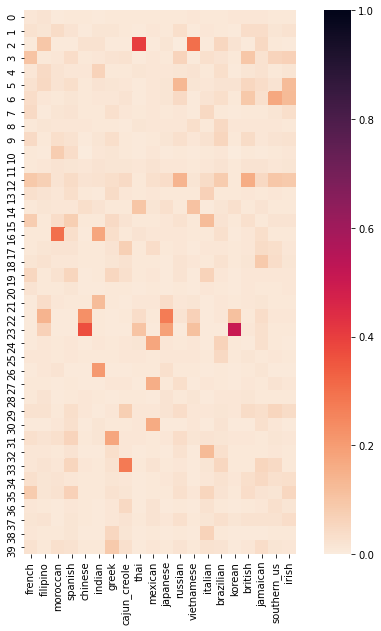

In [334]:
plot_matrix(tc_matrix)

Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 

Жаль, что в датасете нет названий рецептов, иначе темы было бы проще интерпретировать...

### Заключение
В этом задании вы построили несколько моделей LDA, посмотрели, на что влияют гиперпараметры модели и как можно использовать построенную модель. 